# Neural Network for Time-Stepping Prediction of Buildings

In [1]:
from PIL import Image

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
# import torch.utils.data as data_utils
import os
import timeit

import matplotlib.pyplot as plt
import pandas as pd
import random
# import seaborn as sn
from sklearn.metrics import r2_score

from sklearn.preprocessing import StandardScaler

from metaimnet_regression import *

## Set Inputs

In [2]:
seed = 7               # Set seed. Keep this constant for reproducibility.
n_samples = 10000      # How many samples do we keep for training + validation (rest will be used for testing)
num_metaims = 5        # How many meta-IMs do we want to extract from the hazard time history?

In [3]:
path_to_predictor_dataset = 'predictors_new.parquet'           # Set the path to your analysis data file (csv/parquet)
path_to_processed_time_histories = '../../RC_Frame_large/x_gm'                  # Set the path to your ground motions file

## Read Inputs

In [4]:
cols2read = ['storeys', 'bays', 'storey_ht', 'bay_width', 'w_floor', 
             'f_c', 'gm_index', 'pga', 'pgv', 'drift_ratio_pct_max', 'damage_state']

predictors_all = pd.read_parquet(path_to_predictor_dataset, columns = cols2read, engine = 'pyarrow')

# Eliminate Outliers
predictors_all = predictors_all[predictors_all['drift_ratio_pct_max']<20].reset_index(drop = True)

predictors_all['building_ht'] = predictors_all['storeys'] * predictors_all['storey_ht']
predictors_all['building_width'] = predictors_all['bays'] * predictors_all['bay_width']

We assume the collapse capacity of the building to be 12 inches

In [5]:
# capacity = 12
# predictors_all['capacity'] = capacity
# predictors_all['damage_state'] = 0

# predictors_all.loc[predictors_all['tip_displacement']>predictors_all['capacity'], 'damage_state'] = 1

# # predictors_all = predictors_all.drop(columns = ['storeys', 'storey_ht', 'bays', 'bay_width', 'capacity'])

## Prepare training data

In [6]:
train_data, val_data, test_data = create_train_val_test_splits(predictors_all, 
                                                               n_samples = n_samples, 
                                                               split_frac = 0.9, 
                                                               random_seed = seed)

cols2scale = ['building_ht', 'building_width', 'w_floor', 'f_c']
# cols2scale = ['storeys', 'bays', 'storey_ht', 'bay_width', 'w_floor', 'f_c', 'f_st', 'Icol', 'As']
cols_predicted = ['drift_ratio_pct_max']

x_train_scaled, x_val_scaled, x_test_scaled, y_data, y_val, y_test = create_scaled_inputs_outputs(train_data, 
                                                                                                  val_data, 
                                                                                                  test_data, 
                                                                                                  cols2scale,
                                                                                                  cols_predicted = cols_predicted)


## Prepare ground motion features

In [7]:
x_th_all = torch.load(path_to_processed_time_histories)

In [8]:
train_data, val_data, test_data, x_th, x_th_val, x_th_test = split_ground_motions(x_th_all, 
                                                                                  train_data, 
                                                                                  val_data, 
                                                                                  test_data)

In [9]:
del x_th_all

## Train Meta-IMNet

In [10]:
max_epochs = 800
interval = 50

start = timeit.default_timer()
model1, model2, error_evolution_training, error_evolution_val = train_metaimnet_model(x_train_scaled, 
                                                                                   x_val_scaled, 
                                                                                   y_data, 
                                                                                   y_val, 
                                                                                   x_th, 
                                                                                   x_th_val, 
                                                                                   train_data, 
                                                                                   val_data, 
                                                                                   cols2scale,
                                                                                   num_metaims,
                                                                                   max_epochs,
                                                                                   interval,
                                                                                   seed)

stop = timeit.default_timer()

print('Time Elapsed in Model Training: ', stop - start)

Epoch 1: Training RMSE Loss 4.4105, Validation RMSE Loss 4.4373
Epoch 50: Training RMSE Loss 1.7923, Validation RMSE Loss 1.6743
Epoch 100: Training RMSE Loss 1.6552, Validation RMSE Loss 1.5650
Epoch 150: Training RMSE Loss 1.6191, Validation RMSE Loss 1.5565
Epoch 200: Training RMSE Loss 1.5862, Validation RMSE Loss 1.5244
Epoch 250: Training RMSE Loss 1.5500, Validation RMSE Loss 1.5057
Epoch 300: Training RMSE Loss 1.4875, Validation RMSE Loss 1.4895
Epoch 350: Training RMSE Loss 1.4208, Validation RMSE Loss 1.4663
Epoch 400: Training RMSE Loss 1.3457, Validation RMSE Loss 1.3948
Epoch 450: Training RMSE Loss 1.2954, Validation RMSE Loss 1.3737
Epoch 500: Training RMSE Loss 1.2583, Validation RMSE Loss 1.4082
Epoch 550: Training RMSE Loss 1.2172, Validation RMSE Loss 1.3334
Epoch 600: Training RMSE Loss 1.1785, Validation RMSE Loss 1.3094
Epoch 650: Training RMSE Loss 1.1529, Validation RMSE Loss 1.3135
Epoch 700: Training RMSE Loss 1.1094, Validation RMSE Loss 1.3007
Epoch 750: Tr

In [11]:
y_pred_train = predict_metaimnet(model1, model2, x_th, x_train_scaled, train_data)
y_pred_val = predict_metaimnet(model1, model2, x_th_val, x_val_scaled, val_data)

train_data['drift_ratio_pred'] = y_pred_train.detach().view(-1).numpy()

val_data['drift_ratio_pred'] = y_pred_val.detach().view(-1).numpy()

## True v/s Predicted Response on Training Data

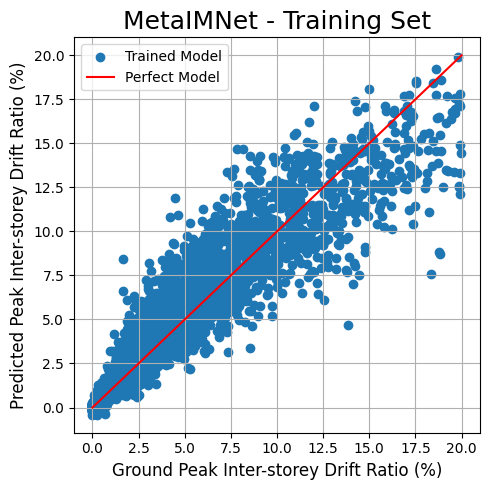

RMSE = 1.052, R2 = 0.894


In [12]:
plot_scatter_results(train_data, 'MetaIMNet - Training Set')

## Loss Evolution

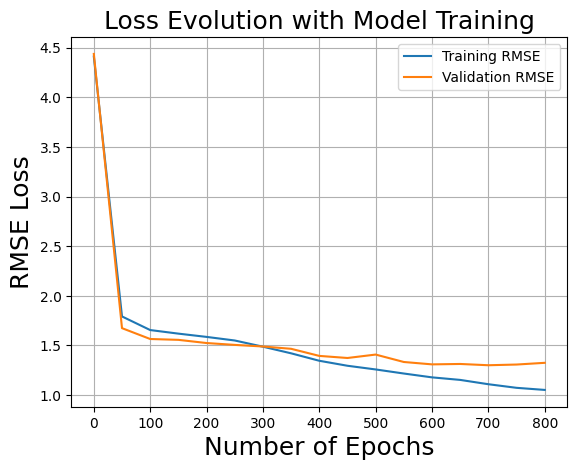

In [13]:
# Loss evolution curve
fig, ax = plt.subplots(1,1)
ax.plot(range(0, interval + max_epochs, interval), error_evolution_training, label = 'Training RMSE')
ax.plot(range(0, interval + max_epochs, interval), error_evolution_val, label = 'Validation RMSE')
# ax.set(title="Loss Evolution with Model Training", xlabel="Number of Epochs", ylabel="MSE Loss")
ax.set_title("Loss Evolution with Model Training", fontsize = 18)
ax.set_xlabel("Number of Epochs", fontsize = 18)
ax.set_ylabel("RMSE Loss", fontsize = 18)
ax.legend()
ax.grid()
plt.show()

## Make Predictions on Test Data

In [14]:
y_pred_test = predict_metaimnet(model1, model2, x_th_test, x_test_scaled, test_data)

test_data['drift_ratio_pred'] = y_pred_test.detach().view(-1).numpy()

## True v/s Predicted Response on Test Data

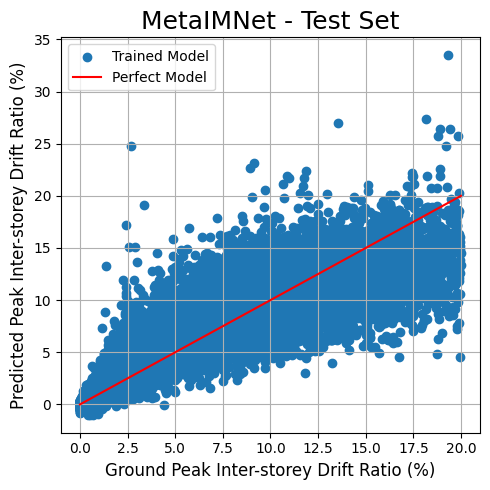

RMSE = 1.24, R2 = 0.851


In [15]:
plot_scatter_results(test_data, 'MetaIMNet - Test Set')

## True v/s Predicted Response on Combined Train, Validation, and Test Data

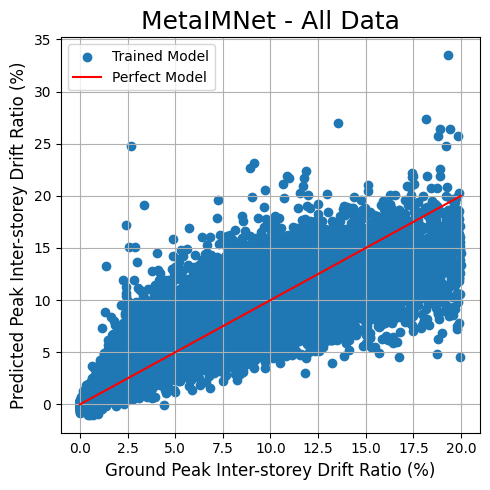

RMSE = 1.222, R2 = 0.855


In [16]:
all_data = pd.concat([train_data, val_data, test_data]).reset_index(drop = True)
plot_scatter_results(all_data, 'MetaIMNet - All Data')

In [17]:
# all_data.to_parquet('all_data_drift_reg.parquet', engine = 'pyarrow')